# Example 10.1 Monte Carlo simulations of wind time series

### Auto-spectral density of turbulence

In this example, we will simulate time series of turbulent wind using the definition of the auto-spectral density of turbulence from the Norwegian regulations for bridge design N400. The auto spectral density is defined by:

$$\frac{S_u(f)f}{\sigma_u^2} = \frac{A_u \hat{f}_u}{\left(1+ 1.5 A_u \hat{f}_u  \right)^{\frac{5}{3}}} $$

The reduced (dimensionless) frequency is defined as:

$$\hat{f}_u = \frac{f {}^xL_u}{V}  $$

We need to convert the auto-spectral density to a function of the frequency in rad/s. The area under the auto spectral density needs to stay the same. This implies that the following relation applies:

$$S_u(f) = 2\pi S_u(\omega) $$

We also introduce the reduced frequency:

$$ \hat{\omega}_u = \frac{\omega {}^xL_u}{V}$$

The following relation apply:

$$\hat{\omega}_u = 2\pi \hat{f}_u $$

The auto-spectral density is thus defined as

$$\frac{S_u(\omega)\omega}{\sigma_u^2} = \frac{ \frac{Au}{2\pi} \hat{\omega}_u}{\left(1+ 1.5 \frac{Au}{2\pi} \hat{\omega}_u  \right)^{\frac{5}{3}}} $$

Here $A_u = 6.8$. We also need the turbulence intensity and the integral length scale. We assume that the turbulence intensity is $I_u = 0.15$. The integral length scale is defined by

$$ ^xL_u = L_1 \left(\frac{z}{z_1}\right)^{0.3} $$

Here $L_1=100$, $z_1 = 10$ and $z=50$

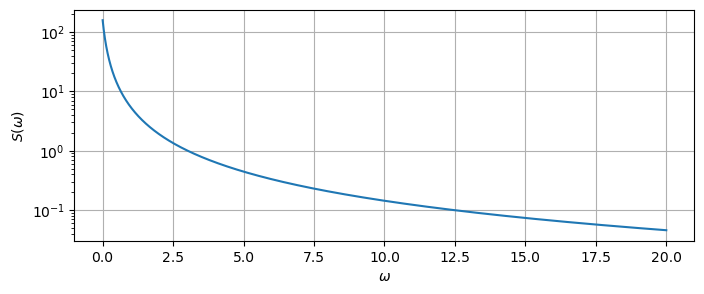

In [3]:
# The auto spectral density of the u-comp according to N400
import numpy as np
from matplotlib import pyplot as plt

omega = np.linspace(0,20,10000)
z=50.0 #Height above ground,
z1=10.0  #Reference height
L1=100.0  #Reference integral length scale z1=10; L1=100;
xLu=L1*(z/z1)**0.3 # Integral length scale
Au=6.8/2/np.pi # Constant in the auto-spectral density
V=40   #Mean wind velocity
Iu=0.15 # Turbulence intensity
Su = (Iu*V)**2*Au*xLu/V/((1+1.5*Au*omega*xLu/V)**(5.0/3.0))
  
plt.figure(figsize=(8,3))
plt.plot(omega,Su)
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.grid()
plt.yscale('log')

 ### Simulate time series from auto-spectral density
The following formula can obtain realizations of the stochastic process.

$$x(t) = \sum_{n=1}^{N}  A_k \cos (\omega_kt + \phi_k) $$

$$A_k = \sqrt{2 S_x(\omega_k) \Delta \omega} $$

Here $S_x(\omega_k)$ is the auto-spectral density of the process, and $\phi_k$ is random phase angles evenly distributed between $0$ and $2\pi$

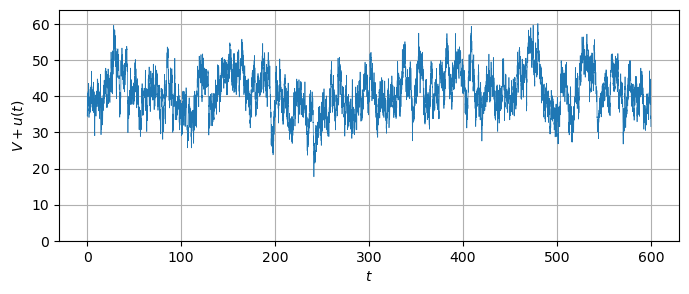

In [13]:

T=600
dt=0.05

N=int(T/dt)

t=np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing
omega_axis = np.arange(0,N,1)*domega # Frequency axis

Su = (Iu*V)**2*Au*xLu/V/((1+1.5*Au*omega_axis*xLu/V)**(5.0/3.0));

phi = np.random.rand(N)*2*np.pi # Random phase angles 
c = (2*Su*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
u = np.real(np.fft.ifft(c)*N) # The IFFT
    
plt.figure(figsize=(8,3))
plt.plot(t,u+V,linewidth=0.5)
plt.ylabel(r'$V+u(t)$')
plt.xlabel(r'$t$')
plt.ylim(0, V*(1+4*Iu))
plt.grid()

### Re-estimate the spectral density

Let's estimate the spectrum of this time series using the Welch method and compare with the target spectrum.


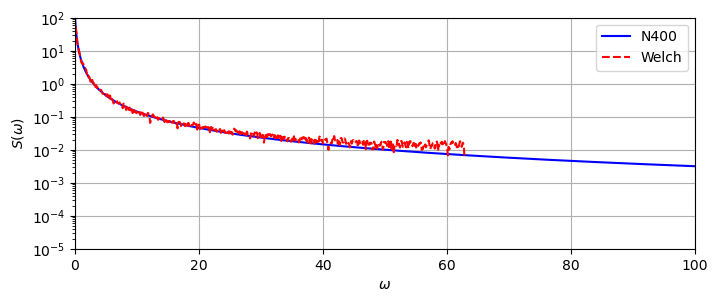

In [14]:
import scipy

Ndivisions=10 # Number of divisions of the time series
Nwindow=np.ceil(len(t)/Ndivisions) # Length of window
Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2

# Spectral matrix

dt=t[1]-t[0]

f_welch, S_Hz=scipy.signal.csd(u,u, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
            
omega_welch=f_welch*2*np.pi # Frequency axis in rad/s
S_welch=S_Hz/(2*np.pi) # Spectrum in rad/s
    
# Plot spectrum
plt.figure(figsize=(8,3))
plt.plot(omega_axis,Su,'-',color='b',label='N400')  
plt.plot(omega_welch,S_welch,'--',color='r',label='Welch')  
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.grid()
plt.xlim(0,100)
plt.ylim(1e-5,1e2)
#plt.xscale('log')
plt.yscale('log')
plt.legend()

### Calculate statistics

Let's calculate the statistics and compare with what we specified for the simulation.


In [12]:
u_mean=np.mean(u+V)
u_std=np.std(u+V)

ti=u_std/u_mean*100 # Turbulence intensity in percent

print('Mean velocity is ' + str(round(u_mean*100)/100) + ' m/s' )

print('Turbulence intensity is ' + str(round(ti*100)/100) + ' %' )


Mean velocity is 39.62 m/s
Turbulence intensity is 15.04 %


### 3 s gust

The 3 second gust can be calculated by considering a 3 s moving average of the wind time series.

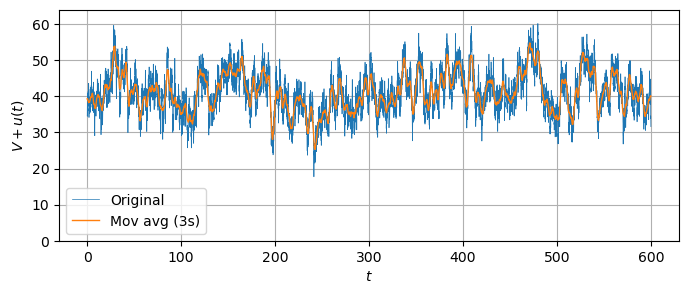

In [18]:

# Example parameters
fs = 1/dt  # Sampling rate
window_duration = 3  # 3 seconds

# Convert 3 seconds to number of samples based on the sampling rate
window_size = int(np.ceil(window_duration * fs))

# Calculate the 3-second moving average using convolution
u_movavg = np.convolve(u, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(8,3))
plt.plot(t,u+V,label='Original',linewidth=0.5)
plt.plot(t,u_movavg+V,label='Mov avg (3s)',linewidth=1)
plt.ylabel(r'$V+u(t)$')
plt.xlabel(r'$t$')
plt.ylim(0, V*(1+4*Iu))
plt.grid()
plt.legend()


The gust factor is defined as:

$$
G=
\dfrac
{V_{gust} }
{V_{mean} }
$$

where $V_{gust}$ is the peak value of a 3 s gust in the considered time series.

In [19]:
print('The gust factor is ' + '{:.2f}'.format(np.max(u_movavg+V)/np.mean(u+V)))

The gust factor is 1.33


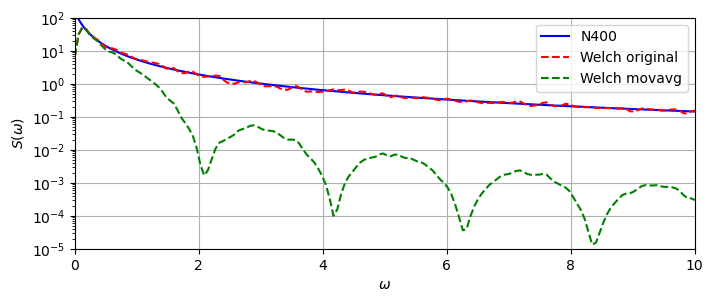

In [9]:
f_welch, S_mov_avg_Hz=scipy.signal.csd(u_movavg,u_movavg, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
            
omega_welch=f_welch*2*np.pi # Frequency axis in rad/s
S_mov_avg=S_mov_avg_Hz/(2*np.pi) # Spectrum in rad/s
    
# Plot spectrum
plt.figure(figsize=(8,3))
plt.plot(omega_axis,Su,'-',color='b',label='N400')  
plt.plot(omega_welch,S_welch,'--',color='r',label='Welch original')  
plt.plot(omega_welch,S_mov_avg,'--',color='g',label='Welch movavg')  
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.grid()
plt.xlim(0,10)
plt.ylim(1e-5,1e2)
#plt.xscale('log')
plt.yscale('log')
plt.legend()